# Árvores II - Tarefa 2

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
X_train = pd.read_csv('X_train.csv').drop(columns='Unnamed: 0')
X_test  = pd.read_csv('X_test.csv').drop(columns='Unnamed: 0')

y_train = pd.read_csv('y_train.csv').drop(columns='Unnamed: 0')
y_test  = pd.read_csv('y_test.csv').drop(columns='Unnamed: 0')

In [5]:
X_train.set_index([X_train.index, 'subject'], inplace=True)
X_test.set_index([X_test.index, 'subject'], inplace=True)
y_train.set_index([y_train.index, 'subject'], inplace=True)
y_test.set_index([y_test.index, 'subject'], inplace=True)

### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Validação. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.25, random_state=1729)

### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.

In [9]:
clf = DecisionTreeClassifier(random_state=2360873, max_depth=4).fit(X_train, y_train)

In [10]:
importancia = clf.feature_importances_

importancia_df = pd.DataFrame({'nome_coluna': X_train.columns,'importance': importancia})

# Pego o nome das 3 colunas mais significativas para o modelo
melhores_variaveis = importancia_df.sort_values(by = 'importance').tail(3)['nome_coluna']

melhores_variaveis

559      angle(Y,gravityMean)
265         fBodyAcc-mean()-X
56     tGravityAcc-energy()-X
Name: nome_coluna, dtype: object

### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.

In [12]:
%%time
X_train_melhores = X_train[['angle(Y,gravityMean)', 'fBodyAcc-mean()-X', 'tGravityAcc-energy()-X']]
X_valid_melhores = X_valid[['angle(Y,gravityMean)', 'fBodyAcc-mean()-X', 'tGravityAcc-energy()-X']]
X_test_melhores = X_test[['angle(Y,gravityMean)', 'fBodyAcc-mean()-X', 'tGravityAcc-energy()-X']]

CPU times: total: 0 ns
Wall time: 6.77 ms


In [13]:
caminho = clf.cost_complexity_pruning_path(X_train_melhores, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])
ccp_alphas

array([0.        , 0.00115172, 0.00593335, 0.00692424, 0.03452797,
       0.07134658, 0.1138304 , 0.16755691, 0.1853135 ])

In [14]:
%%time
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(X_train_melhores, y_train)
    clfs.append(clf)

CPU times: total: 438 ms
Wall time: 458 ms


In [15]:
%%time
train_scores = [clf.score(X_train_melhores, y_train) for clf in clfs]
valid_scores  = [clf.score(X_valid_melhores, y_valid)   for clf in clfs]

CPU times: total: 109 ms
Wall time: 213 ms


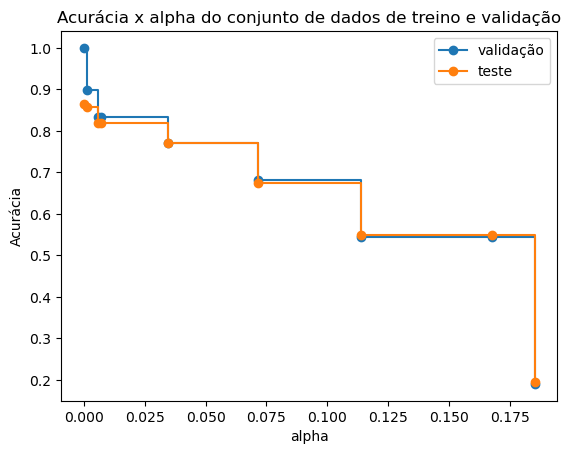

CPU times: total: 562 ms
Wall time: 644 ms


In [16]:
%%time
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e validação")
ax.plot(ccp_alphas, train_scores, marker='o', label="validação",
        drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [17]:
%%time
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.2f}')

melhor_arvore

Acurácia da melhor árvore na base de validação: 86.45
CPU times: total: 15.6 ms
Wall time: 1.07 ms


DecisionTreeClassifier(random_state=2360873)

### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.

Acurácia: 69.09
CPU times: total: 125 ms
Wall time: 142 ms


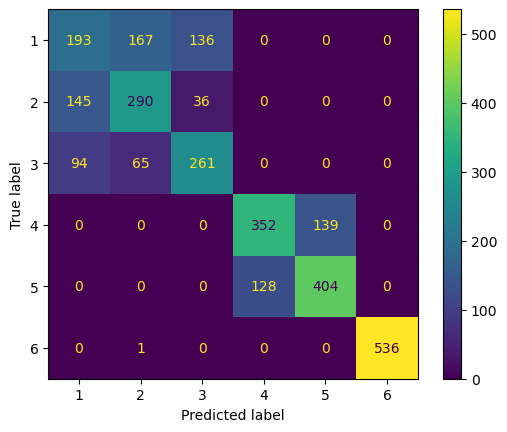

In [19]:
%%time
acuracia_teste = melhor_arvore.score(X_test_melhores, y_test)

print(f'Acurácia: {acuracia_teste*100:.2f}')
ConfusionMatrixDisplay.from_estimator(melhor_arvore, X_test_melhores, y_test);